In [1]:
numHoldemHands = 1326  # nchoosek(52,2)
ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
suits=['c','s','d','h']
numRanks = len(ranks)
numSuits = len(suits)

# Input: N/A
# Output:
#   A map from int hand representation in [0,1235] to tuple of form
#   (rank1, rank2, isSuited).
def makeIntToHandMap():
    result = [0 for i in range(numHoldemHands)]
    c = 0
    for r1 in range(numRanks):
        for r2 in range(r1, numRanks):
            for s1 in range(numSuits):
                for s2 in range(numSuits):
                    if r1 == r2 and s1 >= s2:
                        continue
                    # hand number c corresponds to holding
                    # ranks[r2], suits[s2], ranks[r1], suits[s1]
                    result[c] = (r2, r1, s1 == s2)
                    c += 1
    return result

intToHandMap = makeIntToHandMap()

In [2]:
import numpy as np
pfeqs = np.loadtxt("pf_eqs.dat")
pfconfl = np.loadtxt("pf_confl.dat")

In [3]:
# Input:
#   nHands: total number of simulations we plan to run
#   i: current simulation number
# Output:
#   Fraction of the time we should choose our action randomly.
def epsilon(nHands, i):
    return (nHands - i) / nHands

In [4]:
nParams = 7

# Input:
#   hand: int hand between 0 and 1325
#   isSB: boolean indicating whether position is SB, else BB
#   isGII: boolean indicating whether action is GII, else FOLD
# Output:
#   numpy array containing features describing a state and action
def phi(hand, isSB, isGII):
    rank2, rank1, isSuited = intToHandMap[hand]
    return np.array([1,
                     rank2/numRanks if isGII else 0,
                     rank1/numRanks if isGII else 0,
                     abs(rank2-rank1)**0.25 if isGII else 0,
                     1 if (isSuited and isGII) else 0,
                     1 if isSB else 0,
                     1 if isSB and isGII else 0,
                    ], dtype=np.float64)

In [5]:
# Inputs:
#   theta: vector of parameters of our model
#   phi: vector of features
# Output:
#   Qhat(phi; theta), an estimate of the action-value
def evalModel(theta, phi):
    return np.sum(theta * phi)

In [6]:
# Input: N/A
# Output: tuple of two random hand numbers representing hands
#         that don't conflict.
def dealCards():
    hand1 = hand2 = 0
    while not pfconfl[hand1, hand2]:
        hand1 = np.random.randint(0, numHoldemHands)
        hand2 = np.random.randint(0, numHoldemHands)
    return hand1, hand2

In [7]:
# Input:
#   theta: parameter for current model Qhat
#   hand: hand number
#   isSB: boolean position
#   epsilon: chance of making a random move
# Output:
#   A tuple of form (isGII, qhat, phi) describing the action
#   taken, its value, and its feature vector.
def act(theta, hand, isSB, epsilon):
    phiGII = phi(hand, isSB, True)
    phiFOLD = phi(hand, isSB, False)
    qGII = evalModel(theta, phiGII)
    qFOLD = evalModel(theta, phiFOLD)
    isGII = qGII > qFOLD
    if np.random.rand() < epsilon/2:
        isGII = not isGII
    if isGII:
        return isGII, qGII, phiGII
    else:
        return isGII, qFOLD, phiFOLD

In [8]:
# Input:
#   S: stack size at the beginning of the hand
#   sbHand: SB hand number
#   sbIsGII: boolean indicating SB's action
#   bbHand: BB hand number
#   bbIsGII: boolean indicating BB's action
# Output:
#   A tuple of the form (SB value, BB value) indicating each player's
#   stack size at the end of the hand.
def simulateHand(S, sbHand, sbIsGII, bbHand, bbIsGII):
    if not sbIsGII:
        return (S-0.5, S+0.5)
    if not bbIsGII:
        return (S+1, S-1)
    # GII. Note: neglecting chops!
    sbEquity = pfeqs[sbHand, bbHand]
    if np.random.rand() < sbEquity:
        return (2*S, 0)
    return (0, 2*S)

In [9]:
# Input:
#   S: effective stack size in BB
#   nHands: number of random hands to play
#   alpha: learning rate hyperparameter
# Output:
#   An 7-vector of weights parameterizing our linear model
def mc(S, nHands, alpha):
    # Start with a random guess for theta.
    theta = np.random.rand(nParams)
    for i in range (nHands):
        sbHand, bbHand = dealCards()
        # SB action
        sbIsGII, sbQhat, sbPhi = act(theta, sbHand, True, epsilon(nHands, i))
        # BB action
        bbIsGII, bbQhat, bbPhi = act(theta, bbHand, False, epsilon(nHands, i))
        # get result from environment
        sbReward, bbReward = simulateHand(S, sbHand, sbIsGII, bbHand, bbIsGII)
        # update the model using each player's results
        theta += alpha * (sbReward-sbQhat) * sbPhi
        theta += alpha * (bbReward-bbQhat) * bbPhi
    return theta

In [10]:
theta = mc(10, 10000000, 0.0001)
print(theta)

[ 9.63958991  6.21393165 -1.32694147 -2.80947114  0.19823468 -0.09965523
  0.16079095]


In [11]:
sbGIIRange = np.zeros(numHoldemHands)
bbGIIRange = np.zeros(numHoldemHands)

for i in range(numHoldemHands):
    for isSB, r in [(True, sbGIIRange), (False, bbGIIRange)]:
        qHatGII = evalModel(theta, phi(i, isSB, True))
        qHatFOLD = evalModel(theta, phi(i, isSB, False))
        r[i] = 1 if qHatGII > qHatFOLD else 0

In [12]:
print(np.sum(sbGIIRange)/numHoldemHands)
print(np.sum(bbGIIRange)/numHoldemHands)

0.5173453996983409
0.45248868778280543


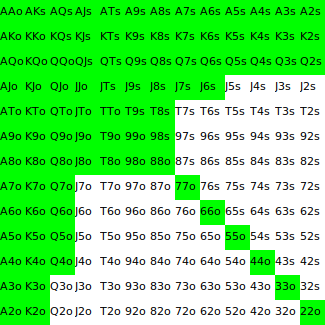

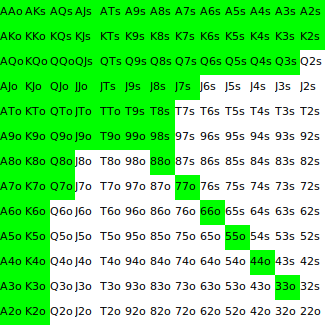

In [13]:
from IPython.display import SVG, display
from collections import defaultdict
        
def drawRange(r):
    weights = defaultdict(int)
    counts = defaultdict(int)
    for i in range(numHoldemHands):
        rank2, rank1, isSuited = intToHandMap[i]
        hand = ranks[rank2] + ranks[rank1] + ('s' if isSuited else 'o')
        weights[hand] += r[i]
        counts[hand] += 1

    svg = '<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="325" height="325">'
    for i in range(len(ranks)):
        for j in range(len(ranks)):
            if i<j:
                hand = ranks[j]+ranks[i]+'s'
            else:
                hand = ranks[i]+ranks[j]+'o'
            frac = weights[hand] / counts[hand]
            hexcolor = '#%02x%02x%02x' % (int(255*(1-frac)), 255, int(255*(1-frac)))
            svg += '<rect x="' + str((len(ranks)-i-1)*25) + '" y="' + str((len(ranks)-j-1)*25) \
                      + '" width="25" height="25" fill="'+hexcolor+'"></rect>'
            svg += '<text x="' + str((len(ranks)-i-1)*25)+'" y="'+str(((len(ranks)-j))*25-10) \
                      + '" font-size="11" >' + hand + '</text>'
    svg += '</svg>'
    
    display(SVG(svg))

drawRange(sbGIIRange)
drawRange(bbGIIRange)